**Author: Oliver Chang**\
**W205 Project1 San Fransisco BikeShare Data Query and Analysis**

# Statement of Purpose
You're a data scientist at Lyft Bay Wheels (https://www.lyft.com/bikes/bay-wheels), formerly known as Ford GoBike, the company running Bay Area Bikeshare.\
You are trying to increase ridership, and you want to offer deals through the mobile app to do so.\
In this project, you will need to do data exploration, cleaning or filtering dirty data, etc.\
Once the data is processed, you will conduct data analysis using Python and make final recommendations to the management.


- What are the 5 most popular trips that you would call "commuter trips"?

    The commuter trips can be defined as regular trips taken by the commuters to/off work. Therefore, the commuter trips exhibit the following characteristics such as regularity in time, directionality in location, and etc.
    In this case, we found that the rush hours were from 6 to 10am and 3 to 7pm, from Monday to Friday based on trip frequency.
    Therefore, we defined commuter trips the trips that satisfied the above criteria. \
    The top 5 commuter trips were:
    
    1.	6632	San Francisco Caltrain 2 (330 Townsend)	 to   Townsend at 7th
    2.	6166	2nd at Townsend	 to  Harry Bridges Plaza (Ferry Building)
    3.	5716	Harry Bridges Plaza (Ferry Building)	to  2nd at Townsend
    4.	5689	Embarcadero at Folsom	to  San Francisco Caltrain (Townsend at 4th)
    5.	5512	Embarcadero at Sansome	to  Steuart at Market
    


In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


- Investigate the frequency of trips across a week.

In [65]:
%%bigquery trips_by_dow

SELECT CASE WHEN EXTRACT(DAYOFWEEK FROM start_date) = 1 THEN "SUN"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 2 THEN "MON"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 3 THEN "TUE"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 4 THEN "WED"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 5 THEN "THR"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 6 THEN "FRI"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 7 THEN "SAT"
            ELSE Null END as day_of_week,      
COUNT(trip_id) as trip_counts,
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
GROUP BY day_of_week 
ORDER BY trip_counts


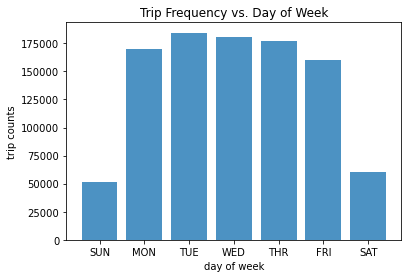

In [75]:
trips_by_dow.to_csv(r'~/w205/project-1-ocychang/trips_by_dow.csv', index = False)
df = pd.read_csv('trips_by_dow.csv')
df.set_index(df.day_of_week, inplace=True)
reorderlist = ['SUN','MON','TUE','WED','THR','FRI','SAT']
df = df.reindex(reorderlist)
plt.bar(df['day_of_week'], df['trip_counts'], align='center', alpha=0.8)
plt.xlabel('day of week')
plt.ylabel('trip counts')
plt.title('Trip Frequency vs. Day of Week')

plt.show()

The results indicate that trips have higher frequency during weekdays and lower on weekends. It suggests that most of the riders may be commuters.

In [72]:
%%bigquery trips_by_hr_mon_to_fri
SELECT COUNT(trip_id) as trip_counts, hours,  FROM
(
SELECT CASE WHEN EXTRACT(DAYOFWEEK FROM start_date) = 1 THEN "SUN"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 2 THEN "MON"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 3 THEN "TUE"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 4 THEN "WED"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 5 THEN "THR"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 6 THEN "FRI"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 7 THEN "SAT"
            ELSE Null END as day_of_week, 
            EXTRACT(HOUR FROM start_date) as hours,
            trip_id,
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
) as inner_table
WHERE day_of_week in ('MON','TUE','WED','THR','FRI')
GROUP BY hours
ORDER BY hours



Further investigate the trip frequency within weekdays (Mon to Fri). 

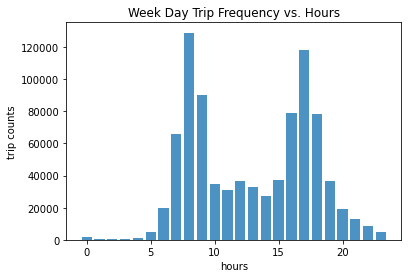

In [75]:
trips_by_hr_mon_to_fri.to_csv(r'~/w205/project-1-ocychang/trips_by_hr_mon_to_fri.csv', index = False)

df = pd.read_csv('trips_by_hr_mon_to_fri.csv')
df.set_index(df.hours, inplace=True)
plt.bar(df['hours'], df['trip_counts'], align='center', alpha=0.8)
plt.xlabel('hours')
plt.ylabel('trip counts')
plt.title('Week Day Trip Frequency vs. Hours')

plt.show()


The figure shows a bimodal distribution of trip frequency with modes at about 8am and 5pm. This further indicates that a great portion of bikeshare riders are commuters. \
Therefore, I am using the above criteria to filter all the trips down to only commuter trips. The criteria includes: (1) within weekdays, and (2) trip between 6am to 10am, and 3pm to 7pm.

Investigate overall top popular trips.

In [34]:
%%bigquery top_5_com_trips

SELECT COUNT(distinct trip_id) as com_trip ,start_station_name, end_station_name FROM
(
SELECT CASE WHEN EXTRACT(DAYOFWEEK FROM start_date) = 1 THEN "SUN"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 2 THEN "MON"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 3 THEN "TUE"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 4 THEN "WED"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 5 THEN "THR"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 6 THEN "FRI"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 7 THEN "SAT"
            ELSE Null END as day_of_week, 
            EXTRACT(HOUR FROM start_date) as hours,
            trip_id,
            start_station_name,
            end_station_name,
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
) as inner_table
WHERE day_of_week in ('MON','TUE','WED','THR','FRI') and hours in (6,7,8,9,10,15,16,17,18,19)
GROUP BY start_station_name, end_station_name 
ORDER BY com_trip DESC
LIMIT 5

# GROUP BY hours
# ORDER BY hours

In [35]:
top_5_com_trips.to_csv(r'~/w205/project-1-ocychang/top_5_com_trips.csv', index = False)
top_5_com_trips

,com_trip,start_station_name,end_station_name
0,6632,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th
1,6166,2nd at Townsend,Harry Bridges Plaza (Ferry Building)
2,5716,Harry Bridges Plaza (Ferry Building),2nd at Townsend
3,5689,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th)
4,5512,Embarcadero at Sansome,Steuart at Market


In [42]:
%%bigquery popular_5_trips

SELECT start_station_name, end_station_name, COUNT(distinct trip_id) as pop_trip 
FROM `bigquery-public-data.san_francisco.bikeshare_trips` 
GROUP BY start_station_name, end_station_name 
ORDER BY pop_trip  DESC LIMIT 5



In [43]:
popular_5_trips.to_csv(r'~/w205/project-1-ocychang/popular_5_trips.csv', index = False)
popular_5_trips

,start_station_name,end_station_name,pop_trip
0,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,9150
1,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,8508
2,2nd at Townsend,Harry Bridges Plaza (Ferry Building),7620
3,Harry Bridges Plaza (Ferry Building),2nd at Townsend,6888
4,Embarcadero at Sansome,Steuart at Market,6874


Investigate top weekend trips.

In [44]:
%%bigquery top_weekend_trips

SELECT COUNT(distinct trip_id) as weekend_trip ,start_station_name, end_station_name FROM
(
SELECT CASE WHEN EXTRACT(DAYOFWEEK FROM start_date) = 1 THEN "SUN"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 2 THEN "MON"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 3 THEN "TUE"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 4 THEN "WED"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 5 THEN "THR"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 6 THEN "FRI"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 7 THEN "SAT"
            ELSE Null END as day_of_week, 
            EXTRACT(HOUR FROM start_date) as hours,
            trip_id,
            start_station_name,
            end_station_name,
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
) as inner_table
WHERE day_of_week in ('SAT','SUN') 
GROUP BY start_station_name, end_station_name 
ORDER BY weekend_trip DESC
LIMIT 5


In [46]:
top_weekend_trips.to_csv(r'~/w205/project-1-ocychang/top_weekend_trips.csv', index = False)
top_weekend_trips

,weekend_trip,start_station_name,end_station_name
0,2078,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome
1,1183,Embarcadero at Sansome,Harry Bridges Plaza (Ferry Building)
2,1146,Embarcadero at Sansome,Embarcadero at Sansome
3,1122,Harry Bridges Plaza (Ferry Building),Harry Bridges Plaza (Ferry Building)
4,701,Embarcadero at Bryant,Embarcadero at Sansome


Investigate the distribution of rider status over time each year (subscriber or not).

In [62]:
%%bigquery rider_status

SELECT subscriber_type, COUNT(distinct trip_id) as trip_count,
EXTRACT(YEAR FROM start_date) as years
FROM `bigquery-public-data.san_francisco.bikeshare_trips` 
GROUP BY subscriber_type, years
ORDER BY years ASC, subscriber_type ASC

In [63]:
rider_status.to_csv(r'~/w205/project-1-ocychang/rider_status.csv', index = False)
rider_status

,subscriber_type,trip_count,years
0,Customer,24499,2013
1,Subscriber,76064,2013
2,Customer,48576,2014
3,Subscriber,277763,2014
4,Customer,40530,2015
5,Subscriber,305722,2015
6,Customer,23204,2016
7,Subscriber,187290,2016


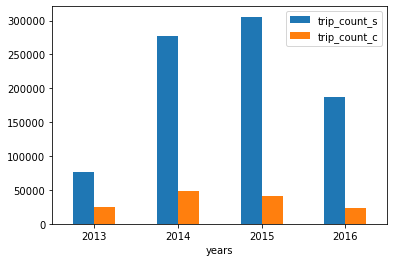

In [122]:
# plot

df = pd.read_csv('rider_status.csv')
df1 = df[(df['subscriber_type']=='Subscriber')]
df2 = df[(df['subscriber_type']=='Customer')]
df1.set_index(df1.years, inplace=True)
df2.set_index(df1.years, inplace=True)
df1.columns = ['subscriber_type',	'trip_count_s',	'years']
df2.columns = ['subscriber_type',	'trip_count_c',	'years']
df3 = pd.concat([df1, df2], axis=1)
df4 = df3[['trip_count_s','trip_count_c']]

ax = df4.plot.bar(rot=0)
# df = pd.read_csv('rider_status.csv')
# df1 = df[(df['subscriber_type']=='Subscriber')]
# df2 = df[(df['subscriber_type']=='Customer')]
# inner_join_df= pd.merge(df1, df2, on='years', how='inner')
# inner_join_df 


The subscribers (blue bar) are the majority of the bikeshare riders. However, both subscribers and single time customer trips declines after 2015. 

Investigate the trip duration distribution for commuters and single trip users.

In [107]:
%%bigquery trip_duration_com

SELECT distinct trip_id, duration_min FROM
(
SELECT CASE WHEN EXTRACT(DAYOFWEEK FROM start_date) = 1 THEN "SUN"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 2 THEN "MON"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 3 THEN "TUE"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 4 THEN "WED"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 5 THEN "THR"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 6 THEN "FRI"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 7 THEN "SAT"
            ELSE Null END as day_of_week, 
            EXTRACT(HOUR FROM start_date) as hours,
            trip_id,
            duration_sec/60 as duration_min
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
) as inner_table
WHERE day_of_week in ('MON','TUE','WED','THR','FRI') and hours in (6,7,8,9,10,15,16,17,18,19)
ORDER BY duration_min DESC


In [36]:
trip_duration_com.describe()

,trip_id,duration_min
count,6.894090e+05,689409.000000
mean,6.964826e+05,12.335325
std,3.793872e+05,67.259985
min,4.069000e+03,1.000000
25%,3.701510e+05,5.783333
50%,7.117820e+05,8.433333
75%,1.022231e+06,11.716667
max,1.338343e+06,18892.333333


99% quantile = 76 min
mode = 7 min


Text(0.5, 1.0, 'Weekday Rush Hours Trip Duration Distribution')

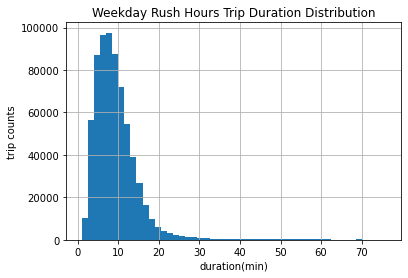

In [127]:
print('99% quantile =',int(trip_duration_com['duration_min'].quantile(0.99)),  'min')
print('mode =',int(trip_duration_com['duration_min'].mode()), 'min')
trip_duration_com99 = trip_duration_com[ trip_duration_com['duration_min']<= 76 ] 
fig, axes = plt.subplots()
trip_duration_com99.hist(column='duration_min',bins=50, ax = axes)
plt.xlabel('duration(min)')
plt.ylabel('trip counts')
plt.title('Weekday Rush Hours Trip Duration Distribution')



In [101]:
%%bigquery trip_duration_rand

SELECT distinct trip_id, duration_min FROM
(
SELECT CASE WHEN EXTRACT(DAYOFWEEK FROM start_date) = 1 THEN "SUN"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 2 THEN "MON"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 3 THEN "TUE"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 4 THEN "WED"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 5 THEN "THR"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 6 THEN "FRI"
            WHEN EXTRACT(DAYOFWEEK FROM start_date) = 7 THEN "SAT"
            ELSE Null END as day_of_week, 
            trip_id,
            duration_sec/60 as duration_min,
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
) as inner_table
WHERE day_of_week in ('SAT','SUN') 
ORDER BY duration_min DESC

In [89]:
trip_duration_rand.describe()

,trip_id,duration_min
count,1.116540e+05,111654.000000
mean,5.969643e+05,41.699662
std,3.954970e+05,887.134667
min,6.481000e+03,1.000000
25%,2.460352e+05,7.216667
50%,5.681685e+05,12.300000
75%,9.209938e+05,23.416667
max,1.333533e+06,287840.000000


95% quantile = 151 min
mode = 0    6.416667
1    6.500000
2    7.666667
dtype: float64 min


Text(0.5, 1.0, 'Weekend Hours Trip Duration Distribution')

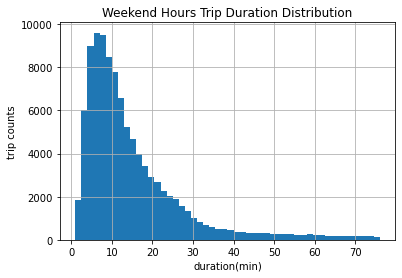

In [125]:
print('95% quantile =',int(trip_duration_rand['duration_min'].quantile(0.95)),  'min')
print('mode =',trip_duration_rand['duration_min'].mode(), 'min')
trip_duration_rand95 = trip_duration_rand[ trip_duration_rand['duration_min']<= 76 ] 

fig, axes = plt.subplots()
trip_duration_rand95.hist(column='duration_min',bins=50, ax = axes)
plt.xlabel('duration(min)')
plt.ylabel('trip counts')
plt.title('Weekend Hours Trip Duration Distribution')


The trip duration distribution is highly skewed both in Weekdays and weekends. The average trip duration in weekdays is 12 mins, and the mode is 7 mins. On weekend, the average duration is 41 mins, and mode is 7 mins. \

The top popular trips on weekdays and weekends are very different. On weekdays, The top trips are:
1.  San Francisco Caltrain 2 (330 Townsend)	Townsend at 7th
2.	6166	2nd at Townsend	Harry Bridges Plaza (Ferry Building)
3.	5716	Harry Bridges Plaza (Ferry Building)	2nd at Townsend
4.	5689	Embarcadero at Folsom	San Francisco Caltrain (Townsend at 4th)
5.	5512	Embarcadero at Sansome	Steuart at Market

The results indicate strong features of commutes, such as ferry and Caltrain. \
\
On the other hand, the top trips on weekends are:
1.	2078	Harry Bridges Plaza (Ferry Building)	Embarcadero at Sansome
2.	1183	Embarcadero at Sansome	Harry Bridges Plaza (Ferry Building)
3.	1146	Embarcadero at Sansome	Embarcadero at Sansome
4.	1122	Harry Bridges Plaza (Ferry Building)	Harry Bridges Plaza (Ferry Building)
5.	701	Embarcadero at Bryant	Embarcadero at Sansome

The results show more rounds trips, which suggests that the riders are tourists who return thier bikes after a spin. In addition, the top trips do not contain caltrain stations, which supports the previous conclusion. The ferry building and Embarcadero at Sansome show up in the results. However, I suspect that both stations here are not for work commute purposes, but for tourism purposes. This indicates the importance of these stations due to thier multi-purpose functionality that bike demands are strong.  


Investigate stations with no available bikes or docks within a week and within a day.

In [48]:
%%bigquery empty_stations

SELECT 
COUNT (bs.bikes_available) as empty_count,
bs.station_id,
bt.name,
FROM `bigquery-public-data.san_francisco.bikeshare_status` as bs
LEFT JOIN `bigquery-public-data.san_francisco.bikeshare_stations` as bt
ON bs.station_id = bt.station_id
WHERE bs.bikes_available =0 
GROUP BY bs.station_id, bt.name
ORDER BY empty_count DESC


In [49]:
empty_stations.head(10)

,empty_count,station_id,name
0,44844,62,2nd at Folsom
1,44728,45,Commercial at Montgomery
2,35903,48,Embarcadero at Vallejo
3,32980,60,Embarcadero at Sansome
4,32505,41,Clay at Battery
5,32027,70,San Francisco Caltrain (Townsend at 4th)
6,31733,73,Grant Avenue at Columbus Avenue
7,30800,76,Market at 4th
8,27938,63,Howard at 2nd
9,25496,82,Broadway St at Battery St


In [66]:
%%bigquery empty_days

SELECT COUNT (bs.bikes_available) as empty_count, 
# bt.name,
CASE WHEN EXTRACT(DAYOFWEEK FROM bs.time) = 1 THEN "SUN"
            WHEN EXTRACT(DAYOFWEEK FROM bs.time) = 2 THEN "MON"
            WHEN EXTRACT(DAYOFWEEK FROM bs.time) = 3 THEN "TUE"
            WHEN EXTRACT(DAYOFWEEK FROM bs.time) = 4 THEN "WED"
            WHEN EXTRACT(DAYOFWEEK FROM bs.time) = 5 THEN "THR"
            WHEN EXTRACT(DAYOFWEEK FROM bs.time) = 6 THEN "FRI"
            WHEN EXTRACT(DAYOFWEEK FROM bs.time) = 7 THEN "SAT"
            ELSE Null END as day_of_week, 
FROM `bigquery-public-data.san_francisco.bikeshare_status` as bs
LEFT JOIN `bigquery-public-data.san_francisco.bikeshare_stations` as bt
ON bs.station_id = bt.station_id
WHERE bs.bikes_available =0 
GROUP BY day_of_week
ORDER BY day_of_week 




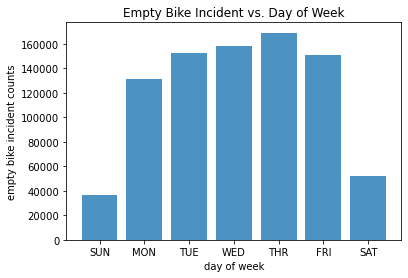

In [71]:
df = empty_days
df.set_index(df.day_of_week, inplace=True)
reorderlist = ['SUN','MON','TUE','WED','THR','FRI','SAT']
df = df.reindex(reorderlist)
plt.bar(df['day_of_week'], df['empty_count'], align='center', alpha=0.8)
plt.xlabel('day of week')
plt.ylabel('empty bike incident counts')
plt.title('Empty Bike Incident vs. Day of Week')

plt.show()


In [72]:
%%bigquery empty_hours

SELECT COUNT (bs.bikes_available) as empty_count, 
EXTRACT(HOUR FROM  bs.time) as hours,
FROM `bigquery-public-data.san_francisco.bikeshare_status` as bs
WHERE bs.bikes_available =0 
GROUP BY hours
ORDER BY hours


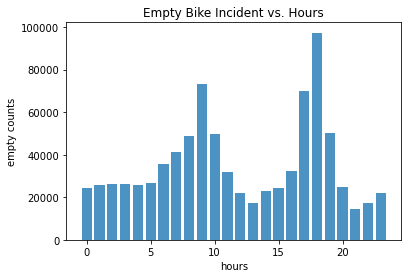

In [77]:
df = empty_hours
df.set_index(df.hours, inplace=True)
plt.bar(df['hours'], df['empty_count'], align='center', alpha=0.8)
plt.xlabel('hours')
plt.ylabel('empty counts')
plt.title('Empty Bike Incident vs. Hours')

plt.show()

In [93]:
%%bigquery empty_dock_stations

SELECT 
COUNT (bs.docks_available) as empty_count,
bs.station_id,
bt.name,
FROM `bigquery-public-data.san_francisco.bikeshare_status` as bs
LEFT JOIN `bigquery-public-data.san_francisco.bikeshare_stations` as bt
ON bs.station_id = bt.station_id
WHERE bs.docks_available =0 
GROUP BY bs.station_id, bt.name
ORDER BY empty_count DESC

In [94]:
empty_dock_stations.head(10)

,empty_count,station_id,name
0,43079,70,San Francisco Caltrain (Townsend at 4th)
1,39401,54,Embarcadero at Bryant
2,33112,73,Grant Avenue at Columbus Avenue
3,25476,60,Embarcadero at Sansome
4,23605,69,San Francisco Caltrain 2 (330 Townsend)
5,18534,65,Townsend at 7th
6,18036,50,Harry Bridges Plaza (Ferry Building)
7,17017,72,Civic Center BART (7th at Market)
8,16824,48,Embarcadero at Vallejo
9,14279,39,Powell Street BART


In [80]:
%%bigquery empty_dock_days

SELECT COUNT (bs.docks_available) as empty_count, 
# bt.name,
CASE WHEN EXTRACT(DAYOFWEEK FROM bs.time) = 1 THEN "SUN"
            WHEN EXTRACT(DAYOFWEEK FROM bs.time) = 2 THEN "MON"
            WHEN EXTRACT(DAYOFWEEK FROM bs.time) = 3 THEN "TUE"
            WHEN EXTRACT(DAYOFWEEK FROM bs.time) = 4 THEN "WED"
            WHEN EXTRACT(DAYOFWEEK FROM bs.time) = 5 THEN "THR"
            WHEN EXTRACT(DAYOFWEEK FROM bs.time) = 6 THEN "FRI"
            WHEN EXTRACT(DAYOFWEEK FROM bs.time) = 7 THEN "SAT"
            ELSE Null END as day_of_week, 
FROM `bigquery-public-data.san_francisco.bikeshare_status` as bs
LEFT JOIN `bigquery-public-data.san_francisco.bikeshare_stations` as bt
ON bs.station_id = bt.station_id
WHERE bs.docks_available =0 
GROUP BY day_of_week
ORDER BY day_of_week 


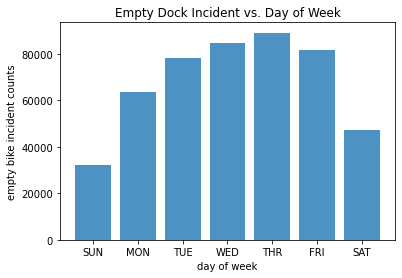

In [90]:
df = empty_dock_days
df.set_index(df.day_of_week, inplace=True)
reorderlist = ['SUN','MON','TUE','WED','THR','FRI','SAT']
df = df.reindex(reorderlist)
plt.bar(df['day_of_week'], df['empty_count'], align='center', alpha=0.8)
plt.xlabel('day of week')
plt.ylabel('empty bike incident counts')
plt.title('Empty Dock Incident vs. Day of Week')

plt.show()

In [87]:
%%bigquery empty_dock_hours

SELECT COUNT (bs.docks_available) as empty_count, 
EXTRACT(HOUR FROM  bs.time) as hours,
FROM `bigquery-public-data.san_francisco.bikeshare_status` as bs
WHERE bs.docks_available =0 
GROUP BY hours
ORDER BY hours



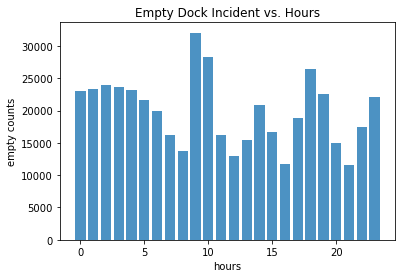

In [89]:
df = empty_dock_hours
df.set_index(df.hours, inplace=True)
plt.bar(df['hours'], df['empty_count'], align='center', alpha=0.8)
plt.xlabel('hours')
plt.ylabel('empty counts')
plt.title('Empty Dock Incident vs. Hours')

plt.show()

The results indicate that the no-bike-available incidents follow the rush hour patterns. There is a higher chance that no bike is available at the stations listed above during weekdays and rush hours.\
On the other hand, the results indicate that the no-dock-available incidents follow the weekday patterns as well. However, it doesn't follow the rush hour pattern. The no-dock-available incidents tend to be very irregular and have multiple peaks during a 24 hour window. 

- What are your recommendations for offers (justify based on your findings)?

1. **Provide more benefits to the subscribers.** Subscribers account for 85+% of the total trips 2013 to 2016. I think providing discounts or credits to the subscribers can help keep the riders under subscription, especially for the ones with the company for years. 

2. **Provide discount and bonus to single time customers.** Although the single time customers are not the majority of the users, it also means there is great potential. I think providing benefits for the single time users during weekends can increase the utilization rate of bikes. For example, work with shops, restaurants, and merchants close to the stations listed above for the weekends and provide rate discount if they vist the stores. 

- Solutions  in 1 and 2 can help address the problem observed at 2016 where the trips dropped significantly.   

3. **Provide free of charge trips for riders who take the bikes from stations with no available docks to the stations with no available bikes.** During rush hours, there is a higher chance that, at some stations, there is no bike available for the users. Instead of hiring movers to transport bikes to the stations, the company can provide incentives, such as free trips, to riders who take the bikes to those stations. The company can further develop an APP to tell the riders where to move the bikes to. The riders can even sell the trips to others if the company makes more money overall.

4. **Provide special offers for shorter trips.** Most of the trips are about 7 to 8 minutes during rush hours. However, there are still trips longer than 10 or 15 minutes. Providing incentives to increase the turn-over rate of bikes can help reduce the issues with no available bike and increase revenue.

5. **Optimize bike allocation based on the analysis.** There are some stations listed above are constantly demanding more bikes and some have enough reserves during rush hours. I suggest that the company re-allocate the bikes across different stations based on the analysis condudcted. It may require more investment in infrastructures, but can increase the trips and revenue. 
